In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda


In [2]:
#Original source: https://www.kaggle.com/code/hojjatk/read-mnist-dataset
#It has been modified for ease of use w/ pytorch

#You do NOT need to modify ANY code in this file!

import numpy as np
import struct
from array import array
import torch

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        n = 60000 if "train" in images_filepath else 10000
        labels = torch.zeros((n, 10))
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            l = torch.tensor(array("B", file.read())).unsqueeze(-1)
            l = torch.concatenate((torch.arange(0, n).unsqueeze(-1), l), dim = 1).type(torch.int32)
            labels[l[:,0], l[:,1]] = 1

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = torch.zeros((n, 28**2))
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            #img = img.reshape(28, 28)
            images[i, :] = torch.tensor(img)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [3]:
import torch

class ReLU:
    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Applies the ReLU activation function.
        ReLU(x) = max(0, x)
        """
        return torch.maximum(torch.zeros_like(x), x)

    def backward(self, delta: torch.tensor, x: torch.tensor) -> torch.tensor:
        """
        Computes the gradient of ReLU.
        ReLU'(x) = 1 if x > 0 else 0
        """
        return delta * (x > 0).float()


class LeakyReLU:
    def __init__(self, alpha=0.1):
        """
        Initializes the LeakyReLU activation function with a specified alpha value.
        """
        self.alpha = alpha

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Applies the Leaky ReLU activation function.
        LeakyReLU(x) = x if x > 0 else alpha * x
        """
        return torch.where(x >= 0, x, self.alpha * x)

    def backward(self, delta: torch.tensor, x: torch.tensor) -> torch.tensor:
        """
        Computes the gradient of Leaky ReLU.
        LeakyReLU'(x) = 1 if x > 0 else alpha
        """
        return delta * torch.where(x >= 0, torch.ones_like(x), self.alpha * torch.ones_like(x))


In [4]:
import torch
import numpy as np
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MLP:
    '''
    Multi-Layer Perceptron (MLP) for MNIST classification.
    Implements forward propagation, backpropagation, and training.
    '''
    
    def __init__(self, layer_sizes: list[int]):
        self.layer_sizes: list[int] = layer_sizes
        self.num_layers = len(layer_sizes) - 1
        self.weights: list[torch.tensor] = []
        self.biases: list[torch.tensor] = []
        self.features: list[torch.tensor] = []  

        self.learning_rate: float = 1
        self.batch_size: int = 1
        self.activation_function: callable[[torch.tensor], torch.tensor] = ReLU

    def set_hp(self, lr: float, bs: int, activation: object) -> None:
        """
        Set hyperparameters for training.
        """
        self.learning_rate = lr
        self.batch_size = bs
        self.activation_function = activation()

    def initialize(self) -> None:
        """
        Initialize all biases to zero and weights using Xavier initialization.
        """
        for i in range(self.num_layers):
            d_in = self.layer_sizes[i]
            d_out = self.layer_sizes[i + 1]
            w_range = np.sqrt(6 / (d_in + d_out))
            W = torch.empty(d_in, d_out, device=device).uniform_(-w_range, w_range)
            self.weights.append(W)
            b = torch.zeros(1, d_out, device=device) 
            self.biases.append(b)
            

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Forward propagation through all layers.
        Applies activation function to all layers except the last one.
        """
        self.features = [x.to(device)]  

        for i in range(self.num_layers):  
            x = torch.matmul(x, self.weights[i]) + self.biases[i]
            x = self.activation_function.forward(x)  
            self.features.append(x) 
        return x

    def backward(self, delta: torch.Tensor) -> None:
        '''
        This function should backpropagate the provided delta through the entire MLP, and update the weights according to the hyper-parameters
        stored in the class variables.
        '''
        # back propogation starts from the result
        for i in reversed(range(self.num_layers)):
            x = self.features[i]

            delta = self.activation_function.backward(delta,self.features[i+1])
            # Computing gradients
            dW = torch.matmul(x.T,delta) / self.batch_size
            db = torch.sum(delta, dim=0, keepdim=True) / self.batch_size

            # Updating weights and biases with learning rate
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db
            delta = torch.matmul(delta,self.weights[i].T)



def TrainMLP(model: MLP, x_train: torch.tensor, y_train: torch.tensor) -> MLP:
    """
    Train the MLP for one epoch using mini-batch gradient descent with GPU support.
    """
    bs = model.batch_size
    N = x_train.shape[0]
    rng = np.random.default_rng()
    idx = rng.permutation(N)

    L = 0  

    for i in tqdm.tqdm(range(N // bs)):
        x = x_train[idx[i * bs:(i + 1) * bs], ...].to(device)
        y = y_train[idx[i * bs:(i + 1) * bs], ...].to(device)

        
        y_hat = model.forward(x)

        
        p = torch.exp(y_hat)
        p /= torch.sum(p, dim=1, keepdim=True)

        
        l = -1 * torch.sum(y * torch.log(p)) ### batch size not required here
        L += l

       
        delta = p - y
        model.backward(delta)

    print("Train Loss:", L / ((N // bs) * bs))



def TestMLP(model: MLP, x_test: torch.tensor, y_test: torch.tensor) -> tuple[float, float]:
    """
    Evaluate the MLP on test data using GPU support.
    """
    bs = model.batch_size
    N = x_test.shape[0]

    rng = np.random.default_rng()
    idx = rng.permutation(N)

    L = 0
    A = 0

    for i in tqdm.tqdm(range(N // bs)):
        x = x_test[idx[i * bs:(i + 1) * bs], ...].to(device)
        y = y_test[idx[i * bs:(i + 1) * bs], ...].to(device)

        y_hat = model.forward(x)

        
        p = torch.exp(y_hat)
        p /= torch.sum(p, dim=1, keepdim=True)

        
        l = -1 * torch.sum(y * torch.log(p))
        L += l.item()

        
        A += torch.sum(torch.argmax(p, dim=1) == torch.argmax(y, dim=1)).item()

    test_loss = L / ((N // bs) * bs)
    test_accuracy = 100 * A / ((N // bs) * bs)

    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy  


def normalize_mnist() -> tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
    '''
    This function loads the MNIST dataset, then normalizes the "X" values to have zero mean, unit variance.
    '''

    #IMPORTANT!!!#
    #UPDATE THE PATH BELOW!#
    base_path = "C:\\Users\\yoges\\Data_Science_Preparation\\CSCI 5922 Neural Networks and Deep Learning\\Lab Assignments\\Lab1Code\\MNIST\\"
    #^^^^^^^^#


    mnist = MnistDataloader(base_path + "train-images.idx3-ubyte", base_path + "train-labels.idx1-ubyte",
                            base_path + "t10k-images.idx3-ubyte", base_path + "t10k-labels.idx1-ubyte")
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_mean = torch.mean(x_train, dim = 0, keepdim = True)
    x_std = torch.std(x_train, dim = 0, keepdim = True)

    x_train -= x_mean
    x_train /= x_std
    x_train[x_train != x_train] = 0

    x_test -= x_mean
    x_test /= x_std
    x_test[x_test != x_test] = 0


    return x_train, y_train, x_test, y_test

def main():
    """
    Main function to train and evaluate the MLP model on MNIST using GPU.
    """
    x_train, y_train, x_test, y_test = normalize_mnist()

   
    model = MLP([784, 256, 10])  
    model.initialize()
    model.set_hp(lr=1e-3, bs=512, activation=ReLU)  
    
    E = 25
    for _ in range(E):
        TrainMLP(model, x_train, y_train)
        TestMLP(model, x_test, y_test)


if __name__ == "__main__":
    main()


Using device: cuda


100%|██████████| 117/117 [00:00<00:00, 279.23it/s]


Train Loss: tensor(2.3654, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 538.61it/s]


Test Loss: nan, Test Accuracy: 19.51%


100%|██████████| 117/117 [00:00<00:00, 469.79it/s]


Train Loss: tensor(2.1565, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 683.56it/s]


Test Loss: nan, Test Accuracy: 29.71%


100%|██████████| 117/117 [00:00<00:00, 460.27it/s]


Train Loss: tensor(1.9800, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 660.71it/s]


Test Loss: nan, Test Accuracy: 38.55%


100%|██████████| 117/117 [00:00<00:00, 438.15it/s]


Train Loss: tensor(1.8002, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 670.82it/s]


Test Loss: nan, Test Accuracy: 50.60%


100%|██████████| 117/117 [00:00<00:00, 455.22it/s]


Train Loss: tensor(1.6139, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 655.17it/s]


Test Loss: nan, Test Accuracy: 57.27%


100%|██████████| 117/117 [00:00<00:00, 469.07it/s]


Train Loss: tensor(1.4506, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 685.95it/s]


Test Loss: nan, Test Accuracy: 61.59%


100%|██████████| 117/117 [00:00<00:00, 417.45it/s]


Train Loss: tensor(1.3142, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 608.75it/s]


Test Loss: nan, Test Accuracy: 65.69%


100%|██████████| 117/117 [00:00<00:00, 487.28it/s]


Train Loss: tensor(1.1966, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 653.52it/s]


Test Loss: nan, Test Accuracy: 69.53%


100%|██████████| 117/117 [00:00<00:00, 476.44it/s]


Train Loss: tensor(1.0928, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 676.85it/s]


Test Loss: nan, Test Accuracy: 72.62%


100%|██████████| 117/117 [00:00<00:00, 445.77it/s]


Train Loss: tensor(1.0039, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 710.85it/s]


Test Loss: nan, Test Accuracy: 75.21%


100%|██████████| 117/117 [00:00<00:00, 492.39it/s]


Train Loss: tensor(0.9295, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 461.23it/s]


Test Loss: nan, Test Accuracy: 77.08%


100%|██████████| 117/117 [00:00<00:00, 474.56it/s]


Train Loss: tensor(0.8669, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 691.09it/s]


Test Loss: nan, Test Accuracy: 78.95%


100%|██████████| 117/117 [00:00<00:00, 461.91it/s]


Train Loss: tensor(0.8143, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 512.93it/s]


Test Loss: nan, Test Accuracy: 80.45%


100%|██████████| 117/117 [00:00<00:00, 462.07it/s]


Train Loss: tensor(0.7693, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 688.26it/s]


Test Loss: nan, Test Accuracy: 81.34%


100%|██████████| 117/117 [00:00<00:00, 452.29it/s]


Train Loss: tensor(0.7305, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 628.92it/s]


Test Loss: nan, Test Accuracy: 82.43%


100%|██████████| 117/117 [00:00<00:00, 421.24it/s]


Train Loss: tensor(0.6963, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 676.90it/s]


Test Loss: nan, Test Accuracy: 83.38%


100%|██████████| 117/117 [00:00<00:00, 478.26it/s]


Train Loss: tensor(0.6666, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 602.37it/s]


Test Loss: nan, Test Accuracy: 83.91%


100%|██████████| 117/117 [00:00<00:00, 436.82it/s]


Train Loss: tensor(0.6404, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 713.69it/s]


Test Loss: nan, Test Accuracy: 84.85%


100%|██████████| 117/117 [00:00<00:00, 405.04it/s]


Train Loss: tensor(0.6176, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 664.49it/s]


Test Loss: nan, Test Accuracy: 85.38%


100%|██████████| 117/117 [00:00<00:00, 474.89it/s]


Train Loss: tensor(0.5970, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 630.81it/s]


Test Loss: nan, Test Accuracy: 85.74%


100%|██████████| 117/117 [00:00<00:00, 475.47it/s]


Train Loss: tensor(0.5788, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 699.98it/s]


Test Loss: nan, Test Accuracy: 86.06%


100%|██████████| 117/117 [00:00<00:00, 465.05it/s]


Train Loss: tensor(0.5621, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 642.47it/s]


Test Loss: nan, Test Accuracy: 86.32%


100%|██████████| 117/117 [00:00<00:00, 453.04it/s]


Train Loss: tensor(0.5475, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 619.73it/s]


Test Loss: nan, Test Accuracy: 86.70%


100%|██████████| 117/117 [00:00<00:00, 491.29it/s]


Train Loss: tensor(0.5337, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 739.06it/s]


Test Loss: nan, Test Accuracy: 86.86%


100%|██████████| 117/117 [00:00<00:00, 470.58it/s]


Train Loss: tensor(0.5211, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 702.01it/s]

Test Loss: nan, Test Accuracy: 87.19%


In [5]:
import pandas as pd


architectures = [
    [784, 128, 10],
    [784, 256, 10],
    [784, 512, 10],
    [784, 128, 64, 10],
    [784, 256, 128, 10]
]


batch_sizes = [512, 256]


activation_functions = [ReLU, LeakyReLU]


results = []

def run_experiment(architecture, batch_size, activation_fn):
    """
    Trains and evaluates the MLP model with a given architecture, batch size, and activation function.
    Returns the Train Loss, Test Loss, and Test Accuracy.
    """
    x_train, y_train, x_test, y_test = normalize_mnist()

    
    model = MLP(architecture)
    model.initialize()
    model.set_hp(lr=1e-3, bs=batch_size, activation=activation_fn)  

    
    model.weights = [w.to(device) for w in model.weights]
    model.biases = [b.to(device) for b in model.biases]

    
    for epoch in range(25):
        TrainMLP(model, x_train, y_train)
    
    
    test_loss, test_accuracy = TestMLP(model, x_test, y_test)

    return test_loss, test_accuracy


for architecture in architectures:
    for batch_size in batch_sizes:
        for activation_fn in activation_functions:
            print(f"\nRunning Model: {architecture}, Batch Size: {batch_size}, Activation: {activation_fn.__name__}")
            
            test_loss, test_accuracy = run_experiment(architecture, batch_size, activation_fn)
            
            
            results.append({
                "Architecture": str(architecture),
                "Batch Size": batch_size,
                "Activation Function": activation_fn.__name__,
                "Test Loss": test_loss,
                "Test Accuracy (%)": test_accuracy
            })


df_results = pd.DataFrame(results)
df_results



Running Model: [784, 128, 10], Batch Size: 512, Activation: ReLU


100%|██████████| 117/117 [00:00<00:00, 277.87it/s]


Train Loss: tensor(2.4505, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 408.84it/s]


Train Loss: tensor(2.2630, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 496.17it/s]


Train Loss: tensor(2.1308, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 478.80it/s]


Train Loss: tensor(2.0303, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 494.63it/s]


Train Loss: tensor(1.9502, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 493.15it/s]


Train Loss: tensor(1.8801, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 503.46it/s]


Train Loss: tensor(1.8102, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 382.03it/s]


Train Loss: tensor(1.7345, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 440.62it/s]


Train Loss: tensor(1.6604, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 457.24it/s]


Train Loss: tensor(1.5938, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 452.47it/s]


Train Loss: tensor(1.5374, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 445.73it/s]


Train Loss: tensor(1.4902, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 477.13it/s]


Train Loss: tensor(1.4506, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 462.48it/s]


Train Loss: tensor(1.4163, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 491.54it/s]


Train Loss: tensor(1.3862, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 361.73it/s]


Train Loss: tensor(1.3589, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 489.59it/s]


Train Loss: tensor(1.3346, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 486.23it/s]


Train Loss: tensor(1.3126, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 479.32it/s]


Train Loss: tensor(1.2931, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 480.75it/s]


Train Loss: tensor(1.2752, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 484.09it/s]


Train Loss: tensor(1.2591, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 515.78it/s]


Train Loss: tensor(1.2445, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 424.17it/s]


Train Loss: tensor(1.2309, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 433.01it/s]


Train Loss: tensor(1.2186, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 492.39it/s]


Train Loss: tensor(1.2072, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 591.54it/s]


Test Loss: nan, Test Accuracy: 62.07%

Running Model: [784, 128, 10], Batch Size: 512, Activation: LeakyReLU


100%|██████████| 117/117 [00:00<00:00, 262.64it/s]


Train Loss: tensor(2.3159, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 312.51it/s]


Train Loss: tensor(2.0556, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 409.70it/s]


Train Loss: tensor(1.8409, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 420.06it/s]


Train Loss: tensor(1.6499, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 401.27it/s]


Train Loss: tensor(1.4725, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 432.24it/s]


Train Loss: tensor(1.3169, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 426.34it/s]


Train Loss: tensor(1.1900, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 458.57it/s]


Train Loss: tensor(1.0892, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 357.71it/s]


Train Loss: tensor(1.0073, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 424.57it/s]


Train Loss: tensor(0.9402, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 435.24it/s]


Train Loss: tensor(0.8834, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 430.18it/s]


Train Loss: tensor(0.8351, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 430.36it/s]


Train Loss: tensor(0.7932, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 376.48it/s]


Train Loss: tensor(0.7569, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 427.70it/s]


Train Loss: tensor(0.7244, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 391.84it/s]


Train Loss: tensor(0.6955, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 420.07it/s]


Train Loss: tensor(0.6702, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 440.34it/s]


Train Loss: tensor(0.6472, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 447.63it/s]


Train Loss: tensor(0.6265, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 435.45it/s]


Train Loss: tensor(0.6078, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 430.39it/s]


Train Loss: tensor(0.5908, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 420.89it/s]


Train Loss: tensor(0.5751, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 348.19it/s]


Train Loss: tensor(0.5612, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 406.63it/s]


Train Loss: tensor(0.5480, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 461.74it/s]


Train Loss: tensor(0.5361, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 591.76it/s]


Test Loss: nan, Test Accuracy: 86.46%

Running Model: [784, 128, 10], Batch Size: 256, Activation: ReLU


100%|██████████| 234/234 [00:00<00:00, 386.71it/s]


Train Loss: tensor(2.1747, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 487.85it/s]


Train Loss: tensor(1.7286, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 488.09it/s]


Train Loss: tensor(1.4405, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 548.72it/s]


Train Loss: tensor(1.2471, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 510.38it/s]


Train Loss: tensor(1.1054, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 458.58it/s]


Train Loss: tensor(0.9639, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 511.45it/s]


Train Loss: tensor(0.8227, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 512.51it/s]


Train Loss: tensor(0.7315, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 478.88it/s]


Train Loss: tensor(0.6711, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 452.17it/s]


Train Loss: tensor(0.6253, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 497.38it/s]


Train Loss: tensor(0.5890, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 517.22it/s]


Train Loss: tensor(0.5587, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 516.49it/s]


Train Loss: tensor(0.5330, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 540.84it/s]


Train Loss: tensor(0.5112, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 439.41it/s]


Train Loss: tensor(0.4921, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 506.27it/s]


Train Loss: tensor(0.4752, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 534.19it/s]


Train Loss: tensor(0.4602, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 529.50it/s]


Train Loss: tensor(0.4469, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 487.65it/s]


Train Loss: tensor(0.4348, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 467.87it/s]


Train Loss: tensor(0.4236, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 519.48it/s]


Train Loss: tensor(0.4139, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 523.35it/s]


Train Loss: tensor(0.4044, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 563.12it/s]


Train Loss: tensor(0.3961, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 452.49it/s]


Train Loss: tensor(0.3881, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 529.99it/s]


Train Loss: tensor(0.3809, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 792.19it/s]


Test Loss: nan, Test Accuracy: 89.68%

Running Model: [784, 128, 10], Batch Size: 256, Activation: LeakyReLU


100%|██████████| 234/234 [00:00<00:00, 337.49it/s]


Train Loss: tensor(2.1000, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 460.03it/s]


Train Loss: tensor(1.5802, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 477.25it/s]


Train Loss: tensor(1.2714, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 463.11it/s]


Train Loss: tensor(1.0659, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 395.65it/s]


Train Loss: tensor(0.9153, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 400.86it/s]


Train Loss: tensor(0.8054, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 477.24it/s]


Train Loss: tensor(0.7266, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 471.97it/s]


Train Loss: tensor(0.6676, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 473.28it/s]


Train Loss: tensor(0.6217, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 412.83it/s]


Train Loss: tensor(0.5847, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 427.06it/s]


Train Loss: tensor(0.5549, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 493.20it/s]


Train Loss: tensor(0.5298, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 484.42it/s]


Train Loss: tensor(0.5082, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 445.65it/s]


Train Loss: tensor(0.4895, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 388.05it/s]


Train Loss: tensor(0.4731, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 469.28it/s]


Train Loss: tensor(0.4587, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 459.17it/s]


Train Loss: tensor(0.4460, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 473.99it/s]


Train Loss: tensor(0.4345, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 416.66it/s]


Train Loss: tensor(0.4239, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 440.83it/s]


Train Loss: tensor(0.4142, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 453.75it/s]


Train Loss: tensor(0.4056, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 457.37it/s]


Train Loss: tensor(0.3975, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 483.11it/s]


Train Loss: tensor(0.3902, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 420.65it/s]


Train Loss: tensor(0.3834, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 477.08it/s]


Train Loss: tensor(0.3767, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 780.34it/s]


Test Loss: nan, Test Accuracy: 89.79%

Running Model: [784, 256, 10], Batch Size: 512, Activation: ReLU


100%|██████████| 117/117 [00:00<00:00, 293.91it/s]


Train Loss: tensor(2.3035, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 445.71it/s]


Train Loss: tensor(2.0282, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 477.62it/s]


Train Loss: tensor(1.8382, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 398.44it/s]


Train Loss: tensor(1.6974, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 468.57it/s]


Train Loss: tensor(1.5747, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 476.44it/s]


Train Loss: tensor(1.4550, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 488.94it/s]


Train Loss: tensor(1.3459, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 496.00it/s]


Train Loss: tensor(1.2566, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 499.28it/s]


Train Loss: tensor(1.1826, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 482.58it/s]


Train Loss: tensor(1.1141, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 503.76it/s]


Train Loss: tensor(1.0468, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 468.98it/s]


Train Loss: tensor(0.9798, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 460.33it/s]


Train Loss: tensor(0.9172, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 492.58it/s]


Train Loss: tensor(0.8623, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 474.46it/s]


Train Loss: tensor(0.8141, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 484.27it/s]


Train Loss: tensor(0.7723, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 506.89it/s]


Train Loss: tensor(0.7345, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 417.55it/s]


Train Loss: tensor(0.7004, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 427.98it/s]


Train Loss: tensor(0.6699, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 445.48it/s]


Train Loss: tensor(0.6431, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 464.92it/s]


Train Loss: tensor(0.6188, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 483.15it/s]


Train Loss: tensor(0.5975, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 490.73it/s]


Train Loss: tensor(0.5787, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 465.69it/s]


Train Loss: tensor(0.5617, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 455.92it/s]


Train Loss: tensor(0.5466, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 660.39it/s]


Test Loss: nan, Test Accuracy: 86.71%

Running Model: [784, 256, 10], Batch Size: 512, Activation: LeakyReLU


100%|██████████| 117/117 [00:00<00:00, 271.78it/s]


Train Loss: tensor(2.2548, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 339.37it/s]


Train Loss: tensor(1.9276, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 355.46it/s]


Train Loss: tensor(1.6359, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 413.33it/s]


Train Loss: tensor(1.3975, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 423.00it/s]


Train Loss: tensor(1.2240, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 396.07it/s]


Train Loss: tensor(1.0941, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 349.38it/s]


Train Loss: tensor(0.9922, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 413.27it/s]


Train Loss: tensor(0.9114, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 365.81it/s]


Train Loss: tensor(0.8463, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 413.68it/s]


Train Loss: tensor(0.7928, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 403.20it/s]


Train Loss: tensor(0.7485, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 429.92it/s]


Train Loss: tensor(0.7109, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 410.36it/s]


Train Loss: tensor(0.6785, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 441.96it/s]


Train Loss: tensor(0.6506, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 426.26it/s]


Train Loss: tensor(0.6265, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 431.34it/s]


Train Loss: tensor(0.6047, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 429.13it/s]


Train Loss: tensor(0.5861, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 446.54it/s]


Train Loss: tensor(0.5688, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 388.98it/s]


Train Loss: tensor(0.5534, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 348.09it/s]


Train Loss: tensor(0.5395, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 379.49it/s]


Train Loss: tensor(0.5267, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 398.34it/s]


Train Loss: tensor(0.5151, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 443.58it/s]


Train Loss: tensor(0.5041, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 437.04it/s]


Train Loss: tensor(0.4942, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 417.90it/s]


Train Loss: tensor(0.4849, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 698.23it/s]


Test Loss: nan, Test Accuracy: 87.91%

Running Model: [784, 256, 10], Batch Size: 256, Activation: ReLU


100%|██████████| 234/234 [00:00<00:00, 413.37it/s]


Train Loss: tensor(2.2983, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 480.02it/s]


Train Loss: tensor(1.8952, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 532.90it/s]


Train Loss: tensor(1.5408, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 546.09it/s]


Train Loss: tensor(1.2548, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 566.35it/s]


Train Loss: tensor(1.0258, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 502.72it/s]


Train Loss: tensor(0.8672, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 546.10it/s]


Train Loss: tensor(0.7619, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 557.48it/s]


Train Loss: tensor(0.6875, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 485.20it/s]


Train Loss: tensor(0.6321, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 556.92it/s]


Train Loss: tensor(0.5889, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 513.71it/s]


Train Loss: tensor(0.5541, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 427.51it/s]


Train Loss: tensor(0.5258, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 508.79it/s]


Train Loss: tensor(0.5017, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 462.89it/s]


Train Loss: tensor(0.4813, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 473.22it/s]


Train Loss: tensor(0.4636, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 522.40it/s]


Train Loss: tensor(0.4480, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 454.10it/s]


Train Loss: tensor(0.4342, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 532.75it/s]


Train Loss: tensor(0.4218, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 527.21it/s]


Train Loss: tensor(0.4106, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 478.77it/s]


Train Loss: tensor(0.4011, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 512.35it/s]


Train Loss: tensor(0.3917, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 578.82it/s]


Train Loss: tensor(0.3835, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 548.88it/s]


Train Loss: tensor(0.3759, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 529.63it/s]


Train Loss: tensor(0.3684, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 513.14it/s]


Train Loss: tensor(0.3620, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 425.63it/s]


Test Loss: nan, Test Accuracy: 90.35%

Running Model: [784, 256, 10], Batch Size: 256, Activation: LeakyReLU


100%|██████████| 234/234 [00:00<00:00, 362.58it/s]


Train Loss: tensor(2.1895, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 417.19it/s]


Train Loss: tensor(1.6276, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 422.01it/s]


Train Loss: tensor(1.2540, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 455.14it/s]


Train Loss: tensor(1.0309, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 430.03it/s]


Train Loss: tensor(0.8822, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 466.47it/s]


Train Loss: tensor(0.7792, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 480.31it/s]


Train Loss: tensor(0.7050, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 480.28it/s]


Train Loss: tensor(0.6493, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 463.01it/s]


Train Loss: tensor(0.6059, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 425.27it/s]


Train Loss: tensor(0.5711, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 451.62it/s]


Train Loss: tensor(0.5424, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 441.39it/s]


Train Loss: tensor(0.5185, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 470.42it/s]


Train Loss: tensor(0.4975, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 455.65it/s]


Train Loss: tensor(0.4802, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 496.32it/s]


Train Loss: tensor(0.4645, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 441.61it/s]


Train Loss: tensor(0.4506, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 429.16it/s]


Train Loss: tensor(0.4382, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 454.03it/s]


Train Loss: tensor(0.4273, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 439.19it/s]


Train Loss: tensor(0.4171, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 432.36it/s]


Train Loss: tensor(0.4080, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 458.20it/s]


Train Loss: tensor(0.3995, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 462.33it/s]


Train Loss: tensor(0.3916, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 455.04it/s]


Train Loss: tensor(0.3841, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 465.71it/s]


Train Loss: tensor(0.3780, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 455.57it/s]


Train Loss: tensor(0.3714, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 717.62it/s]


Test Loss: nan, Test Accuracy: 89.99%

Running Model: [784, 512, 10], Batch Size: 512, Activation: ReLU


100%|██████████| 117/117 [00:00<00:00, 293.69it/s]


Train Loss: tensor(2.3261, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 447.12it/s]


Train Loss: tensor(1.9867, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 484.89it/s]


Train Loss: tensor(1.7155, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 499.71it/s]


Train Loss: tensor(1.4929, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 494.90it/s]


Train Loss: tensor(1.2973, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 515.54it/s]


Train Loss: tensor(1.1488, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 537.12it/s]


Train Loss: tensor(1.0378, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 497.79it/s]


Train Loss: tensor(0.9504, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 518.14it/s]


Train Loss: tensor(0.8797, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 533.78it/s]


Train Loss: tensor(0.8207, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 519.64it/s]


Train Loss: tensor(0.7711, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 514.30it/s]


Train Loss: tensor(0.7282, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 543.28it/s]


Train Loss: tensor(0.6909, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 474.70it/s]


Train Loss: tensor(0.6585, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 478.40it/s]


Train Loss: tensor(0.6303, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 480.49it/s]


Train Loss: tensor(0.6051, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 499.25it/s]


Train Loss: tensor(0.5832, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 483.71it/s]


Train Loss: tensor(0.5641, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 432.93it/s]


Train Loss: tensor(0.5465, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 476.76it/s]


Train Loss: tensor(0.5309, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 415.94it/s]


Train Loss: tensor(0.5169, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 448.16it/s]


Train Loss: tensor(0.5037, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 529.36it/s]


Train Loss: tensor(0.4922, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 462.10it/s]


Train Loss: tensor(0.4815, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 494.06it/s]


Train Loss: tensor(0.4716, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 683.95it/s]


Test Loss: nan, Test Accuracy: 88.11%

Running Model: [784, 512, 10], Batch Size: 512, Activation: LeakyReLU


100%|██████████| 117/117 [00:00<00:00, 292.81it/s]


Train Loss: tensor(2.2854, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 359.10it/s]


Train Loss: tensor(1.8359, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 402.53it/s]


Train Loss: tensor(1.4889, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 389.28it/s]


Train Loss: tensor(1.2385, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 387.93it/s]


Train Loss: tensor(1.0673, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 464.06it/s]


Train Loss: tensor(0.9469, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 453.30it/s]


Train Loss: tensor(0.8586, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 453.52it/s]


Train Loss: tensor(0.7916, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 418.07it/s]


Train Loss: tensor(0.7381, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 444.55it/s]


Train Loss: tensor(0.6957, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 379.64it/s]


Train Loss: tensor(0.6600, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 401.05it/s]


Train Loss: tensor(0.6300, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 414.28it/s]


Train Loss: tensor(0.6040, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 414.73it/s]


Train Loss: tensor(0.5815, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 437.86it/s]


Train Loss: tensor(0.5618, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 409.16it/s]


Train Loss: tensor(0.5439, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 467.19it/s]


Train Loss: tensor(0.5286, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 419.68it/s]


Train Loss: tensor(0.5143, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 491.36it/s]


Train Loss: tensor(0.5011, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 478.76it/s]


Train Loss: tensor(0.4899, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 468.96it/s]


Train Loss: tensor(0.4791, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 458.95it/s]


Train Loss: tensor(0.4692, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 449.78it/s]


Train Loss: tensor(0.4601, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 438.14it/s]


Train Loss: tensor(0.4517, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 454.67it/s]


Train Loss: tensor(0.4438, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 543.03it/s]


Test Loss: nan, Test Accuracy: 89.00%

Running Model: [784, 512, 10], Batch Size: 256, Activation: ReLU


100%|██████████| 234/234 [00:00<00:00, 425.33it/s]


Train Loss: tensor(2.1655, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 533.55it/s]


Train Loss: tensor(1.6914, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 508.84it/s]


Train Loss: tensor(1.3295, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 534.46it/s]


Train Loss: tensor(1.0298, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 524.01it/s]


Train Loss: tensor(0.8482, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 503.78it/s]


Train Loss: tensor(0.7396, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 541.01it/s]


Train Loss: tensor(0.6666, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 537.06it/s]


Train Loss: tensor(0.6124, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 561.53it/s]


Train Loss: tensor(0.5706, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 529.76it/s]


Train Loss: tensor(0.5371, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 578.10it/s]


Train Loss: tensor(0.5098, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 558.96it/s]


Train Loss: tensor(0.4864, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 528.31it/s]


Train Loss: tensor(0.4670, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 512.16it/s]


Train Loss: tensor(0.4500, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 490.98it/s]


Train Loss: tensor(0.4349, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 521.07it/s]


Train Loss: tensor(0.4218, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 519.87it/s]


Train Loss: tensor(0.4099, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 536.51it/s]


Train Loss: tensor(0.3995, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 544.95it/s]


Train Loss: tensor(0.3900, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 536.57it/s]


Train Loss: tensor(0.3811, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 522.31it/s]


Train Loss: tensor(0.3729, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 506.42it/s]


Train Loss: tensor(0.3655, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 528.27it/s]


Train Loss: tensor(0.3590, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 574.02it/s]


Train Loss: tensor(0.3524, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 587.61it/s]


Train Loss: tensor(0.3464, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 957.57it/s]


Test Loss: nan, Test Accuracy: 91.08%

Running Model: [784, 512, 10], Batch Size: 256, Activation: LeakyReLU


100%|██████████| 234/234 [00:00<00:00, 374.85it/s]


Train Loss: tensor(2.1207, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 459.33it/s]


Train Loss: tensor(1.4470, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 480.76it/s]


Train Loss: tensor(1.0768, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 490.55it/s]


Train Loss: tensor(0.8805, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 470.31it/s]


Train Loss: tensor(0.7606, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 484.91it/s]


Train Loss: tensor(0.6799, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 487.33it/s]


Train Loss: tensor(0.6216, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 490.60it/s]


Train Loss: tensor(0.5771, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 455.10it/s]


Train Loss: tensor(0.5423, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 461.73it/s]


Train Loss: tensor(0.5144, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 476.92it/s]


Train Loss: tensor(0.4907, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 493.30it/s]


Train Loss: tensor(0.4711, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 502.22it/s]


Train Loss: tensor(0.4541, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 463.18it/s]


Train Loss: tensor(0.4393, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 479.17it/s]


Train Loss: tensor(0.4259, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 466.07it/s]


Train Loss: tensor(0.4144, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 496.00it/s]


Train Loss: tensor(0.4040, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 504.41it/s]


Train Loss: tensor(0.3945, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 471.83it/s]


Train Loss: tensor(0.3860, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 486.53it/s]


Train Loss: tensor(0.3781, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 501.49it/s]


Train Loss: tensor(0.3709, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 515.43it/s]


Train Loss: tensor(0.3643, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 470.39it/s]


Train Loss: tensor(0.3579, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 523.19it/s]


Train Loss: tensor(0.3523, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 517.00it/s]


Train Loss: tensor(0.3467, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 732.81it/s]


Test Loss: nan, Test Accuracy: 90.94%

Running Model: [784, 128, 64, 10], Batch Size: 512, Activation: ReLU


100%|██████████| 117/117 [00:00<00:00, 293.20it/s]


Train Loss: tensor(2.2958, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 334.42it/s]


Train Loss: tensor(2.1450, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 398.80it/s]


Train Loss: tensor(2.0052, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 404.56it/s]


Train Loss: tensor(1.8826, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 411.43it/s]


Train Loss: tensor(1.7757, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 404.32it/s]


Train Loss: tensor(1.6827, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 408.09it/s]


Train Loss: tensor(1.6016, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 393.53it/s]


Train Loss: tensor(1.5310, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 368.76it/s]


Train Loss: tensor(1.4683, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 332.57it/s]


Train Loss: tensor(1.4119, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 378.76it/s]


Train Loss: tensor(1.3606, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 384.84it/s]


Train Loss: tensor(1.3127, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 412.11it/s]


Train Loss: tensor(1.2666, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 416.48it/s]


Train Loss: tensor(1.2214, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 365.44it/s]


Train Loss: tensor(1.1751, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 408.46it/s]


Train Loss: tensor(1.1289, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 318.48it/s]


Train Loss: tensor(1.0837, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 312.02it/s]


Train Loss: tensor(1.0415, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 345.31it/s]


Train Loss: tensor(1.0031, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 371.77it/s]


Train Loss: tensor(0.9693, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 407.78it/s]


Train Loss: tensor(0.9387, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 414.76it/s]


Train Loss: tensor(0.9116, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 404.35it/s]


Train Loss: tensor(0.8871, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 416.27it/s]


Train Loss: tensor(0.8648, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 361.14it/s]


Train Loss: tensor(0.8448, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 584.12it/s]


Test Loss: nan, Test Accuracy: 77.64%

Running Model: [784, 128, 64, 10], Batch Size: 512, Activation: LeakyReLU


100%|██████████| 117/117 [00:00<00:00, 238.44it/s]


Train Loss: tensor(2.3168, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 333.69it/s]


Train Loss: tensor(2.1733, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 300.20it/s]


Train Loss: tensor(2.0355, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 302.33it/s]


Train Loss: tensor(1.8876, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 335.63it/s]


Train Loss: tensor(1.7320, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 312.35it/s]


Train Loss: tensor(1.5821, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 315.67it/s]


Train Loss: tensor(1.4484, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 298.60it/s]


Train Loss: tensor(1.3314, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 321.44it/s]


Train Loss: tensor(1.2305, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 320.41it/s]


Train Loss: tensor(1.1432, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 316.78it/s]


Train Loss: tensor(1.0672, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 305.95it/s]


Train Loss: tensor(1.0010, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 328.45it/s]


Train Loss: tensor(0.9433, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 327.52it/s]


Train Loss: tensor(0.8927, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 314.85it/s]


Train Loss: tensor(0.8479, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 341.29it/s]


Train Loss: tensor(0.8080, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 282.56it/s]


Train Loss: tensor(0.7728, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 307.28it/s]


Train Loss: tensor(0.7410, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 310.83it/s]


Train Loss: tensor(0.7125, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 316.41it/s]


Train Loss: tensor(0.6864, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 356.23it/s]


Train Loss: tensor(0.6630, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 345.47it/s]


Train Loss: tensor(0.6419, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 301.60it/s]


Train Loss: tensor(0.6223, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 301.96it/s]


Train Loss: tensor(0.6046, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 298.53it/s]


Train Loss: tensor(0.5878, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 518.31it/s]


Test Loss: nan, Test Accuracy: 84.96%

Running Model: [784, 128, 64, 10], Batch Size: 256, Activation: ReLU


100%|██████████| 234/234 [00:00<00:00, 346.94it/s]


Train Loss: tensor(2.3532, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 381.77it/s]


Train Loss: tensor(2.1238, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 407.54it/s]


Train Loss: tensor(1.9690, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 393.91it/s]


Train Loss: tensor(1.8291, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 396.76it/s]


Train Loss: tensor(1.6858, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 405.16it/s]


Train Loss: tensor(1.5178, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 395.63it/s]


Train Loss: tensor(1.3259, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 375.95it/s]


Train Loss: tensor(1.1405, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 382.30it/s]


Train Loss: tensor(0.9880, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 339.39it/s]


Train Loss: tensor(0.8705, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 376.52it/s]


Train Loss: tensor(0.7803, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 439.83it/s]


Train Loss: tensor(0.7100, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 421.55it/s]


Train Loss: tensor(0.6549, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 420.26it/s]


Train Loss: tensor(0.6106, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 358.18it/s]


Train Loss: tensor(0.5741, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 387.36it/s]


Train Loss: tensor(0.5438, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 401.18it/s]


Train Loss: tensor(0.5182, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 395.58it/s]


Train Loss: tensor(0.4965, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 399.70it/s]


Train Loss: tensor(0.4775, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 399.02it/s]


Train Loss: tensor(0.4608, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 396.61it/s]


Train Loss: tensor(0.4461, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 405.98it/s]


Train Loss: tensor(0.4331, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 415.01it/s]


Train Loss: tensor(0.4214, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 412.12it/s]


Train Loss: tensor(0.4105, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 402.25it/s]


Train Loss: tensor(0.4009, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 781.85it/s]


Test Loss: nan, Test Accuracy: 89.36%

Running Model: [784, 128, 64, 10], Batch Size: 256, Activation: LeakyReLU


100%|██████████| 234/234 [00:00<00:00, 268.18it/s]


Train Loss: tensor(2.2997, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 342.82it/s]


Train Loss: tensor(2.0050, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 352.98it/s]


Train Loss: tensor(1.7550, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 344.57it/s]


Train Loss: tensor(1.5023, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 340.05it/s]


Train Loss: tensor(1.2743, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 347.53it/s]


Train Loss: tensor(1.0946, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 314.01it/s]


Train Loss: tensor(0.9568, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 342.96it/s]


Train Loss: tensor(0.8506, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 395.24it/s]


Train Loss: tensor(0.7687, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 374.15it/s]


Train Loss: tensor(0.7049, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 339.42it/s]


Train Loss: tensor(0.6534, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 344.27it/s]


Train Loss: tensor(0.6117, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 349.50it/s]


Train Loss: tensor(0.5776, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 335.28it/s]


Train Loss: tensor(0.5485, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 353.80it/s]


Train Loss: tensor(0.5237, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 342.20it/s]


Train Loss: tensor(0.5023, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 353.19it/s]


Train Loss: tensor(0.4836, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 346.51it/s]


Train Loss: tensor(0.4666, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 355.09it/s]


Train Loss: tensor(0.4519, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 336.57it/s]


Train Loss: tensor(0.4386, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 342.61it/s]


Train Loss: tensor(0.4268, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 358.62it/s]


Train Loss: tensor(0.4156, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 317.66it/s]


Train Loss: tensor(0.4055, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 297.61it/s]


Train Loss: tensor(0.3963, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 306.51it/s]


Train Loss: tensor(0.3879, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 674.78it/s]


Test Loss: nan, Test Accuracy: 89.63%

Running Model: [784, 256, 128, 10], Batch Size: 512, Activation: ReLU


100%|██████████| 117/117 [00:00<00:00, 278.36it/s]


Train Loss: tensor(2.4359, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 327.37it/s]


Train Loss: tensor(2.2967, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 438.59it/s]


Train Loss: tensor(2.1946, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 428.24it/s]


Train Loss: tensor(2.1002, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 364.71it/s]


Train Loss: tensor(1.9990, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 399.68it/s]


Train Loss: tensor(1.8781, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 409.36it/s]


Train Loss: tensor(1.7294, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 436.14it/s]


Train Loss: tensor(1.5768, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 365.09it/s]


Train Loss: tensor(1.4397, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 398.60it/s]


Train Loss: tensor(1.3183, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 407.18it/s]


Train Loss: tensor(1.2111, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 372.35it/s]


Train Loss: tensor(1.1170, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 408.92it/s]


Train Loss: tensor(1.0356, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 353.73it/s]


Train Loss: tensor(0.9646, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 328.67it/s]


Train Loss: tensor(0.9034, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 332.63it/s]


Train Loss: tensor(0.8500, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 369.56it/s]


Train Loss: tensor(0.8035, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 337.65it/s]


Train Loss: tensor(0.7630, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 380.85it/s]


Train Loss: tensor(0.7270, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 374.79it/s]


Train Loss: tensor(0.6949, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 364.94it/s]


Train Loss: tensor(0.6664, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 392.92it/s]


Train Loss: tensor(0.6409, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 402.12it/s]


Train Loss: tensor(0.6180, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 325.95it/s]


Train Loss: tensor(0.5973, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 367.43it/s]


Train Loss: tensor(0.5784, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 689.27it/s]


Test Loss: nan, Test Accuracy: 85.40%

Running Model: [784, 256, 128, 10], Batch Size: 512, Activation: LeakyReLU


100%|██████████| 117/117 [00:00<00:00, 252.97it/s]


Train Loss: tensor(2.3851, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 293.05it/s]


Train Loss: tensor(2.1798, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 327.31it/s]


Train Loss: tensor(2.0096, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 294.36it/s]


Train Loss: tensor(1.8568, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 314.72it/s]


Train Loss: tensor(1.7170, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 360.54it/s]


Train Loss: tensor(1.5913, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 339.49it/s]


Train Loss: tensor(1.4786, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 303.10it/s]


Train Loss: tensor(1.3788, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 367.10it/s]


Train Loss: tensor(1.2908, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 362.11it/s]


Train Loss: tensor(1.2136, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 349.28it/s]


Train Loss: tensor(1.1466, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 364.84it/s]


Train Loss: tensor(1.0883, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 352.24it/s]


Train Loss: tensor(1.0377, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 299.64it/s]


Train Loss: tensor(0.9940, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 346.41it/s]


Train Loss: tensor(0.9557, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 335.11it/s]


Train Loss: tensor(0.9214, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 323.05it/s]


Train Loss: tensor(0.8907, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 321.00it/s]


Train Loss: tensor(0.8621, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 307.88it/s]


Train Loss: tensor(0.8351, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 298.70it/s]


Train Loss: tensor(0.8068, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 323.10it/s]


Train Loss: tensor(0.7757, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 359.25it/s]


Train Loss: tensor(0.7387, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 324.58it/s]


Train Loss: tensor(0.6975, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 296.01it/s]


Train Loss: tensor(0.6576, device='cuda:0')


100%|██████████| 117/117 [00:00<00:00, 306.62it/s]


Train Loss: tensor(0.6233, device='cuda:0')


100%|██████████| 19/19 [00:00<00:00, 552.11it/s]


Test Loss: nan, Test Accuracy: 85.26%

Running Model: [784, 256, 128, 10], Batch Size: 256, Activation: ReLU


100%|██████████| 234/234 [00:00<00:00, 318.31it/s]


Train Loss: tensor(2.2079, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 366.18it/s]


Train Loss: tensor(1.9322, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 389.78it/s]


Train Loss: tensor(1.6251, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 435.08it/s]


Train Loss: tensor(1.3998, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 379.20it/s]


Train Loss: tensor(1.2402, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 395.11it/s]


Train Loss: tensor(1.1146, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 408.27it/s]


Train Loss: tensor(1.0162, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 380.22it/s]


Train Loss: tensor(0.9417, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 417.40it/s]


Train Loss: tensor(0.8846, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 398.18it/s]


Train Loss: tensor(0.8395, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 387.83it/s]


Train Loss: tensor(0.8029, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 408.02it/s]


Train Loss: tensor(0.7729, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 420.11it/s]


Train Loss: tensor(0.7475, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 396.15it/s]


Train Loss: tensor(0.7258, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 381.68it/s]


Train Loss: tensor(0.7070, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 374.12it/s]


Train Loss: tensor(0.6910, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 430.03it/s]


Train Loss: tensor(0.6764, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 443.84it/s]


Train Loss: tensor(0.6635, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 394.76it/s]


Train Loss: tensor(0.6514, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 392.37it/s]


Train Loss: tensor(0.6416, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 418.68it/s]


Train Loss: tensor(0.6323, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 377.16it/s]


Train Loss: tensor(0.6236, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 406.44it/s]


Train Loss: tensor(0.6154, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 433.77it/s]


Train Loss: tensor(0.6081, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 382.54it/s]


Train Loss: tensor(0.6008, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 705.68it/s]


Test Loss: nan, Test Accuracy: 79.60%

Running Model: [784, 256, 128, 10], Batch Size: 256, Activation: LeakyReLU


100%|██████████| 234/234 [00:00<00:00, 271.25it/s]


Train Loss: tensor(2.3353, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 316.57it/s]


Train Loss: tensor(2.1278, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 343.75it/s]


Train Loss: tensor(1.8941, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 326.00it/s]


Train Loss: tensor(1.6275, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 332.99it/s]


Train Loss: tensor(1.3969, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 335.73it/s]


Train Loss: tensor(1.2150, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 337.03it/s]


Train Loss: tensor(1.1043, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 342.32it/s]


Train Loss: tensor(1.0076, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 355.43it/s]


Train Loss: tensor(0.8688, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 336.24it/s]


Train Loss: tensor(0.7426, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 310.44it/s]


Train Loss: tensor(0.6607, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 339.83it/s]


Train Loss: tensor(0.6043, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 295.88it/s]


Train Loss: tensor(0.5611, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 331.46it/s]


Train Loss: tensor(0.5268, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 314.62it/s]


Train Loss: tensor(0.4990, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 332.51it/s]


Train Loss: tensor(0.4752, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 320.62it/s]


Train Loss: tensor(0.4558, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 332.87it/s]


Train Loss: tensor(0.4384, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 328.65it/s]


Train Loss: tensor(0.4234, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 356.42it/s]


Train Loss: tensor(0.4101, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 370.09it/s]


Train Loss: tensor(0.3980, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 334.71it/s]


Train Loss: tensor(0.3877, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 375.66it/s]


Train Loss: tensor(0.3780, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 367.86it/s]


Train Loss: tensor(0.3692, device='cuda:0')


100%|██████████| 234/234 [00:00<00:00, 330.56it/s]


Train Loss: tensor(0.3607, device='cuda:0')


100%|██████████| 39/39 [00:00<00:00, 517.75it/s]


Test Loss: nan, Test Accuracy: 90.02%


,Architecture,Batch Size,Activation Function,Test Loss,Test Accuracy (%)
0,"[784, 128, 10]",512,ReLU,NaN,62.068257
1,"[784, 128, 10]",512,LeakyReLU,NaN,86.461760
2,"[784, 128, 10]",256,ReLU,NaN,89.683494
3,"[784, 128, 10]",256,LeakyReLU,NaN,89.793670
4,"[784, 256, 10]",512,ReLU,NaN,86.708470
5,"[784, 256, 10]",512,LeakyReLU,NaN,87.911184
6,"[784, 256, 10]",256,ReLU,NaN,90.354567
7,"[784, 256, 10]",256,LeakyReLU,NaN,89.993990
8,"[784, 512, 10]",512,ReLU,NaN,88.106497
9,"[784, 512, 10]",512,LeakyReLU,NaN,89.000822


In [6]:
df_results

,Architecture,Batch Size,Activation Function,Test Loss,Test Accuracy (%)
0,"[784, 128, 10]",512,ReLU,NaN,62.068257
1,"[784, 128, 10]",512,LeakyReLU,NaN,86.461760
2,"[784, 128, 10]",256,ReLU,NaN,89.683494
3,"[784, 128, 10]",256,LeakyReLU,NaN,89.793670
4,"[784, 256, 10]",512,ReLU,NaN,86.708470
5,"[784, 256, 10]",512,LeakyReLU,NaN,87.911184
6,"[784, 256, 10]",256,ReLU,NaN,90.354567
7,"[784, 256, 10]",256,LeakyReLU,NaN,89.993990
8,"[784, 512, 10]",512,ReLU,NaN,88.106497
9,"[784, 512, 10]",512,LeakyReLU,NaN,89.000822


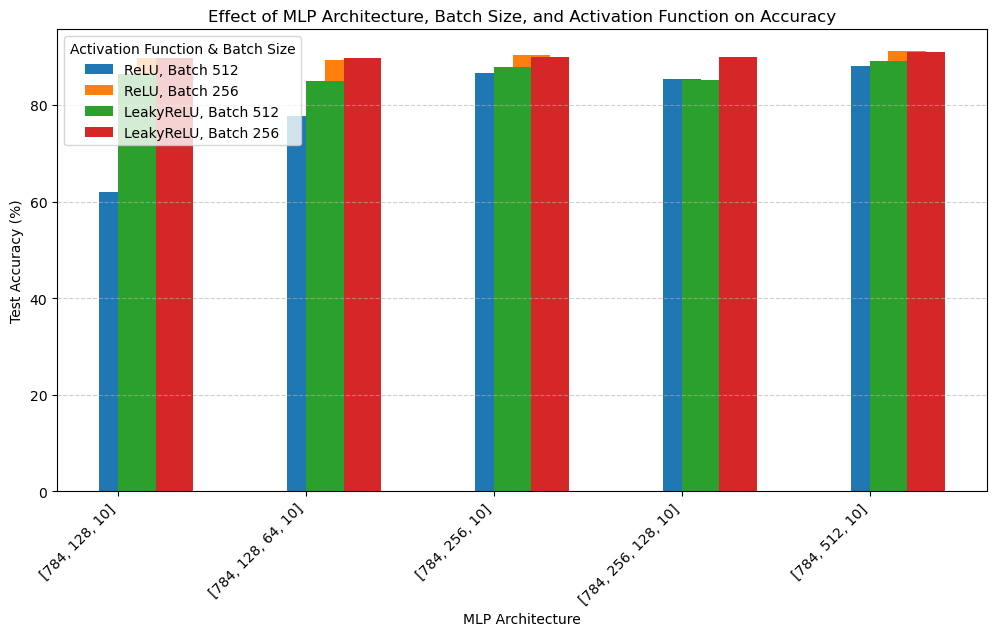

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Updated Data
data = {
    "Architecture": [
        "[784, 128, 10]", "[784, 128, 10]", "[784, 128, 10]", "[784, 128, 10]", 
        "[784, 256, 10]", "[784, 256, 10]", "[784, 256, 10]", "[784, 256, 10]",
        "[784, 512, 10]", "[784, 512, 10]", "[784, 512, 10]", "[784, 512, 10]",
        "[784, 128, 64, 10]", "[784, 128, 64, 10]", "[784, 128, 64, 10]", "[784, 128, 64, 10]",
        "[784, 256, 128, 10]", "[784, 256, 128, 10]", "[784, 256, 128, 10]", "[784, 256, 128, 10]"
    ],
    "Batch Size": [512, 512, 256, 256, 512, 512, 256, 256, 512, 512, 256, 256, 512, 512, 256, 256, 512, 512, 256, 256],
    "Activation Function": [
        "ReLU", "LeakyReLU", "ReLU", "LeakyReLU", 
        "ReLU", "LeakyReLU", "ReLU", "LeakyReLU",
        "ReLU", "LeakyReLU", "ReLU", "LeakyReLU",
        "ReLU", "LeakyReLU", "ReLU", "LeakyReLU",
        "ReLU", "LeakyReLU", "ReLU", "LeakyReLU"
    ],
    "Test Accuracy (%)": [
        62.06, 86.46, 89.68, 89.79, 
        86.70, 87.91, 90.35, 89.99, 
        88.10, 89.00, 91.07, 90.93, 
        77.64, 84.96, 89.36, 89.63, 
        85.40, 85.25, 79.59, 90.02
    ]
}

df_results = pd.DataFrame(data)

# Plot
plt.figure(figsize=(12, 6))

# Sort data for better visualization
df_results.sort_values(by=["Architecture", "Batch Size", "Activation Function"], inplace=True)

architectures = df_results["Architecture"].unique()
x = range(len(architectures))

width = 0.2  # Width of the bars

# Plot bars for each activation function and batch size combination
for i, activation in enumerate(["ReLU", "LeakyReLU"]):
    for j, batch_size in enumerate([512, 256]):
        subset = df_results[(df_results["Activation Function"] == activation) & (df_results["Batch Size"] == batch_size)]
        plt.bar(
            [a + (i * 0.1) + (j * width) for a in x], 
            subset["Test Accuracy (%)"], 
            width=width, 
            label=f"{activation}, Batch {batch_size}"
        )

# Labels and formatting
plt.xticks(x, architectures, rotation=45, ha="right")
plt.xlabel("MLP Architecture")
plt.ylabel("Test Accuracy (%)")
plt.title("Effect of MLP Architecture, Batch Size, and Activation Function on Accuracy")
plt.legend(title="Activation Function & Batch Size")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()
